In [51]:
import csv,random,pickle,os,zipfile,string,keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_hub as hub
#########################################################
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
###################################################################
from nltk import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#########################################################
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import TextVectorization
#########################################################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
#########################################################
from scipy.stats import linregress
from unidecode import unidecode

In [88]:
def step_1_get_dataframe(filename, filetype="json",encoding=None):
    if filetype == "csv":
        train_df = pd.read_csv(filename,encoding=encoding)
    if filetype == "json":
        train_df = pd.read_json(filename,encoding=encoding)
    train_df.drop_duplicates(keep='first').count()
    train_df = train_df.dropna()
    train_df_shuffled = train_df.sample(frac=1, random_state=42)  # shuffle with random_state=42 for reproducibility
    print(train_df_shuffled.head())
    print(train_df_shuffled.columns)
    return train_df_shuffled

def remove_columns(df, cols: list, ):
    df.drop(cols, axis=1, inplace=True)
    print(df.head)
    print(df.columns)
    return df

def label_count_rebalancing(df,labels):
    dataframes = []
    print("### Old count: ")
    print(df.labels.value_counts())
    for label in labels:
        dataframes.append(df[df['labels'] == label])

    lowest = 9999999999
    for df in dataframes:
        if len(df) < lowest:
            lowest = len(df)

    balanced_df = []
    for df in dataframes:
        balanced_df.append(
            resample(df, replace=False, n_samples=lowest)
        )

    train_df = pd.concat(balanced_df)
    print(f"### New counts ")
    print(train_df.labels.value_counts())
    return train_df.sample(frac=1, random_state=42)

def rename_column(df,original, new, ):
    df.rename({original: new}, axis=1, inplace=True)
    print(df.columns)
    return df

In [115]:
train_df = step_1_get_dataframe("email_data/SMS_train.csv","csv",'ISO-8859-1')
val_df = step_1_get_dataframe("email_data/SMS_test.csv","csv",'ISO-8859-1')

     S. No.                                       Message_body     Label
835     836                          K:)eng rocking in ashes:)  Non-Spam
477     478     No no. I will check all rooms befor activities  Non-Spam
350     351          I accidentally brought em home in the box  Non-Spam
890     891                            Ü ready then call me...  Non-Spam
854     855  Thats cool princess! I will cover your face in...  Non-Spam
Index(['S. No.', 'Message_body', 'Label'], dtype='object')
    S. No.                                       Message_body     Label
18      19  Call Germany for only 1 pence per minute! Call...      Spam
42      43  You'll not rcv any more msgs from the chat svc...      Spam
36      37  URGENT! We are trying to contact you. Last wee...      Spam
76      77            Have you laid your airtel line to rest?  Non-Spam
53      54  As a valued customer, I am pleased to advise y...      Spam
Index(['S. No.', 'Message_body', 'Label'], dtype='object')


In [116]:
train_df = remove_columns(train_df,'S. No.')
val_df = remove_columns(val_df,'S. No.')

<bound method NDFrame.head of                                           Message_body     Label
835                          K:)eng rocking in ashes:)  Non-Spam
477     No no. I will check all rooms befor activities  Non-Spam
350          I accidentally brought em home in the box  Non-Spam
890                            Ü ready then call me...  Non-Spam
854  Thats cool princess! I will cover your face in...  Non-Spam
..                                                 ...       ...
106  I will treasure every moment we spend together...  Non-Spam
270  Well good morning mr . Hows london treatin' ya...  Non-Spam
860  Wow so healthy. Old airport rd lor. Cant thk o...  Non-Spam
435  Hmm... Dunno leh, mayb a bag 4 goigng out dat ...  Non-Spam
102  URGENT! Last weekend's draw shows that you hav...      Spam

[957 rows x 2 columns]>
Index(['Message_body', 'Label'], dtype='object')
<bound method NDFrame.head of                                           Message_body     Label
18   Call Germany for

In [117]:
train_df = rename_column(train_df,"Label","labels")
val_df = rename_column(val_df,"Label","labels")

Index(['Message_body', 'labels'], dtype='object')
Index(['Message_body', 'labels'], dtype='object')


In [118]:
train_df = label_count_rebalancing(train_df,["Non-Spam","Spam"])

### Old count: 
labels
Non-Spam    835
Spam        122
Name: count, dtype: int64
### New counts 
labels
Non-Spam    122
Spam        122
Name: count, dtype: int64


In [119]:
label_encoder = LabelEncoder()

train_sentences = train_df.Message_body
train_labels = label_encoder.fit_transform(train_df.labels)

validation_sentences = val_df.Message_body
validation_labels = label_encoder.fit_transform(val_df.labels)



In [104]:
validation_sentences

18     Call Germany for only 1 pence per minute! Call...
42     You'll not rcv any more msgs from the chat svc...
36     URGENT! We are trying to contact you. Last wee...
76               Have you laid your airtel line to rest?
53     As a valued customer, I am pleased to advise y...
                             ...                        
106                  At WHAT TIME should i come tomorrow
14     Ur cash-balance is currently 500 pounds - to m...
92     For ur chance to win a £250 wkly shopping spre...
51     Did you hear about the new "Divorce Barbie"? I...
102    URGENT! This is the 2nd attempt to contact U!U...
Name: Message_body, Length: 125, dtype: object

In [94]:
print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(validation_sentences)} sentences for validation.\n")
print(f"There are {len(validation_labels)} labels for validation.")

There are 244 sentences for training.

There are 244 labels for training.

There are 125 sentences for validation.

There are 125 labels for validation.


In [120]:
tokenizer = Tokenizer(oov_token = "<OOV>")
tokenizer.fit_on_texts(train_sentences)

In [121]:
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

In [122]:
train_seqs = tokenizer.texts_to_sequences(train_sentences)
val_seqs = tokenizer.texts_to_sequences(validation_sentences)

In [123]:
train_pad_sqs = pad_sequences(train_seqs,maxlen=30,padding="post",truncating="post")
val_pad_seqs = pad_sequences(val_seqs,maxlen=30,padding="post",truncating="post")

In [124]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,output_dim=64,input_length=30),
        tf.keras.layers.LSTM(16,return_sequences=True),
        tf.keras.layers.LSTM(8),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

In [125]:
history = model.fit(train_pad_sqs,train_labels,epochs=10, validation_data=(val_pad_seqs, validation_labels))

Epoch 1/10


2023-09-30 12:33:44.047043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 12:33:44.235107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 12:33:44.301127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 12:33:44.494313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/8 [==>...........................] - ETA: 10s - loss: 0.6937 - accuracy: 0.4375

2023-09-30 12:33:44.636268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.4754

2023-09-30 12:33:45.737784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 12:33:45.812487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-30 12:33:45.876468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 3s 196ms/step - loss: 0.6900 - accuracy: 0.4754 - val_loss: 0.6896 - val_accuracy: 0.3920
Epoch 2/10
8/8 [==============================] - 1s 68ms/step - loss: 0.6766 - accuracy: 0.5492 - val_loss: 0.6801 - val_accuracy: 0.4480
Epoch 3/10
8/8 [==============================] - 0s 57ms/step - loss: 0.6579 - accuracy: 0.6680 - val_loss: 0.6672 - val_accuracy: 0.5120
Epoch 4/10
8/8 [==============================] - 0s 50ms/step - loss: 0.6306 - accuracy: 0.7582 - val_loss: 0.6418 - val_accuracy: 0.6400
Epoch 5/10
8/8 [==============================] - 0s 47ms/step - loss: 0.5815 - accuracy: 0.8279 - val_loss: 0.6033 - val_accuracy: 0.7120
Epoch 6/10
8/8 [==============================] - 0s 39ms/step - loss: 0.5118 - accuracy: 0.9098 - val_loss: 0.5409 - val_accuracy: 0.8160
Epoch 7/10
8/8 [==============================] - 0s 41ms/step - loss: 0.4318 - accuracy: 0.9508 - val_loss: 0.4735 - val_accuracy: 0.8880
Epoch 8/10
8/8 [=====================

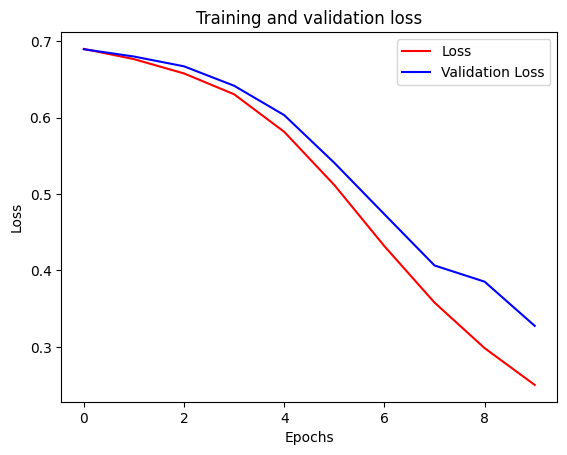

In [126]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(10)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [108]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Test the slope of your val_loss curve. val_loss curve should be 0.0005 at maximum.
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.03708
